## Max and Min metrics

In [1]:
#########################################
# 1. IMPORT LIBRARIES & SET GLOBAL VARS #
#########################################

import os
from os.path import exists
import glob
import re
import sys


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import xarray as xr

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import gdown

# Threshold used for selecting reliable voxels.
NCSNR_THRESHOLD = 0.2


from PIL import Image

from sklearn.manifold import MDS
from sklearn.decomposition import PCA

import sys

import pickle

In [2]:
#########################################
# 2. HELPER FUNCTIONS                   #
#########################################

def r2_over_nc(y, y_pred, ncsnr):
    """
    Compute the R^2 score normalized by the noise ceiling (NC) as in Finzi et al (2022).
    The noise ceiling is computed as:
         NC = ncsnr^2 / (ncsnr^2 + 1/num_trials)
    If ncsnr is None, return the standard R^2.
    """
    ### TODO: Replace the code below with your implementation.
    # Instructions:
    # 1. If ncsnr is None, compute and return the standard R^2 score using
    #    r2_score_sklearn (with multioutput="raw_values").
    # 2. Otherwise, assume there are 3 target trials (i.e. set num_trials = 3.0).
    # 3. Compute the noise ceiling (NC) using the formula:
    #       NC = (ncsnr ** 2) / ( (ncsnr ** 2) + (1.0 / num_trials) )
    # 4. Compute the standard R^2 score (using r2_score_sklearn) and then
    #    return the normalized R^2 score by dividing the R^2 score by NC.
    pass


def get_metadata_concat_hemi(Y):
    """
    Concatenate left- and right-hemisphere metadata for voxels labeled 'nsdgeneral'
    and return the corresponding ncsnr values and metadata DataFrame.
    """
    ncsnr_full = np.concatenate((
        Y['voxel_metadata']['lh']['lh.ncsnr'],
        Y['voxel_metadata']['rh']['rh.ncsnr']
    ))
    
    nsdgeneral_idx = np.concatenate((
        Y['voxel_metadata']['lh']['lh.nsdgeneral.label'],
        Y['voxel_metadata']['rh']['rh.nsdgeneral.label']
    ))
    nsdgeneral_mask = np.logical_and(nsdgeneral_idx == 'nsdgeneral', ncsnr_full > 0)
    ncsnr_nsdgeneral = ncsnr_full[nsdgeneral_mask]
    
    metadata_lh = pd.DataFrame(Y['voxel_metadata']['lh'])
    metadata_rh = pd.DataFrame(Y['voxel_metadata']['rh'])
    nsdgeneral_metadata_df = pd.concat([metadata_lh, metadata_rh])[nsdgeneral_mask]
    
    return ncsnr_nsdgeneral, nsdgeneral_metadata_df


def get_data_dict(Y, brain_data_rep_averaged, ncsnr_nsdgeneral, nsdgeneral_metadata_df, verbose=True):
    """
    For each brain area (both streams and visual ROIs), select voxels with reliable responses
    (ncsnr above threshold) and return a dictionary with responses and ncsnr values.
    """
    data_dict = {}

    # Process streams-based areas.
    for area in ['ventral', 'parietal', 'lateral']:
        data_dict[area] = {}
        lh_area_mask = nsdgeneral_metadata_df['lh.streams.label'].astype(str).str.contains(area, na=False)
        rh_area_mask = nsdgeneral_metadata_df['rh.streams.label'].astype(str).str.contains(area, na=False)
        area_mask = np.logical_or(lh_area_mask, rh_area_mask)
        area_mask = np.logical_and(area_mask, ncsnr_nsdgeneral > NCSNR_THRESHOLD)
        
        if verbose:
            print(f"Size of area {area}: {np.sum(area_mask)}")
        
        area_data = brain_data_rep_averaged[:, area_mask]
        data_dict[area]["responses"] = area_data.copy()
        data_dict[area]["ncsnr"] = ncsnr_nsdgeneral[area_mask].copy()
        
        if verbose:
            print(f"Shape of area {area} responses: {data_dict[area]['responses'].shape}")

    # Process visual ROIs.
    for area in ['V1', 'V2', 'V3', 'V4']:
        data_dict[area] = {}
        lh_area_mask = nsdgeneral_metadata_df['lh.prf-visualrois.label'].astype(str).str.contains(area, na=False)
        rh_area_mask = nsdgeneral_metadata_df['rh.prf-visualrois.label'].astype(str).str.contains(area, na=False)
        area_mask = np.logical_or(lh_area_mask, rh_area_mask)
        area_mask = np.logical_and(area_mask, ncsnr_nsdgeneral > NCSNR_THRESHOLD)
        
        if verbose:
            print(f"Size of area {area}: {np.sum(area_mask)}")
        
        area_data = brain_data_rep_averaged[:, area_mask]
        data_dict[area]["responses"] = area_data.copy()
        data_dict[area]["ncsnr"] = ncsnr_nsdgeneral[area_mask].copy()
        
        if verbose:
            print(f"Shape of area {area} responses: {data_dict[area]['responses'].shape}")

    return data_dict

In [3]:
#########################################
# 3. DOWNLOAD & LOAD NSD DATA           #
#########################################

# Create a data directory if it does not exist.
datadir = os.path.join(os.getcwd(), 'data')
os.makedirs(datadir, exist_ok=True)

subjects = ['subj01', 'subj02', 'subj05', 'subj07']

Ydict = {}

for subj in subjects:

    # Define subject and corresponding file_id.
    overwrite = False

    if subj == 'subj01':
        file_id = '13cRiwhjurCdr4G2omRZSOMO_tmatjdQr'
    elif subj == 'subj02':
        file_id = '1MO9reLoV4fqu6Weh4gmE78KJVtxg72ID'
    elif subj == 'subj05':
        file_id = '11dPt3Llj6eAEDJnaRy8Ch5CxfeKijX_t'
    elif subj == 'subj07':
        file_id = '1HX-6t4c6js6J_vP4Xo0h1fbK2WINpwem'
        
    url = f'https://drive.google.com/uc?id={file_id}&export=download'
    output = os.path.join(datadir, f'{subj}_nativesurface_nsdgeneral.pkl')

    if not exists(output) or overwrite:
        gdown.download(url, output, quiet=False)

    # Load NSD data.
    Y = np.load(output, allow_pickle=True)
    print("Keys in Y:", Y.keys())

    Ydict[subj] = Y


    # Print shapes of image bricks for each partition.
    for partition in ['train', 'val', 'test']:
        print(f"Shape of image brick ({partition}):", Y['image_data'][partition].shape)


Keys in Y: dict_keys(['image_data', 'brain_data', 'voxel_metadata', 'image_metadata'])
Shape of image brick (train): (1000, 425, 425, 3)
Shape of image brick (val): (1000, 425, 425, 3)
Shape of image brick (test): (1000, 425, 425, 3)
Keys in Y: dict_keys(['image_data', 'brain_data', 'voxel_metadata', 'image_metadata'])
Shape of image brick (train): (1000, 425, 425, 3)
Shape of image brick (val): (1000, 425, 425, 3)
Shape of image brick (test): (1000, 425, 425, 3)
Keys in Y: dict_keys(['image_data', 'brain_data', 'voxel_metadata', 'image_metadata'])
Shape of image brick (train): (1000, 425, 425, 3)
Shape of image brick (val): (1000, 425, 425, 3)
Shape of image brick (test): (1000, 425, 425, 3)
Keys in Y: dict_keys(['image_data', 'brain_data', 'voxel_metadata', 'image_metadata'])
Shape of image brick (train): (1000, 425, 425, 3)
Shape of image brick (val): (1000, 425, 425, 3)
Shape of image brick (test): (1000, 425, 425, 3)


In [4]:
subjects

['subj01', 'subj02', 'subj05', 'subj07']

In [5]:

#########################################
# 5. PREPARE FMRI DATA                  #
#########################################
human_data = []

for i in range(4):
    Y = Ydict[subjects[i]]
    # Concatenate full brain ncsnr and nsdgeneral labels.
    ncsnr_full = np.concatenate((
        Y['voxel_metadata']['lh']['lh.ncsnr'].values,
        Y['voxel_metadata']['rh']['rh.ncsnr'].values
    ))
    nsdgeneral_idx = np.concatenate((
        Y['voxel_metadata']['lh']['lh.nsdgeneral.label'].values,
        Y['voxel_metadata']['rh']['rh.nsdgeneral.label'].values
    ))
    print(ncsnr_full.shape, round(np.mean(ncsnr_full), 4), round(np.std(ncsnr_full), 4))
    print(np.unique(nsdgeneral_idx))
    print(np.count_nonzero(nsdgeneral_idx == 'nsdgeneral'))
    
    # Select only nsdgeneral voxels with positive ncsnr.
    nsdgeneral_mask = np.logical_and(nsdgeneral_idx == 'nsdgeneral', ncsnr_full > 0)
    ncsnr_nsdgeneral = ncsnr_full[nsdgeneral_mask]
    print(ncsnr_nsdgeneral.shape, round(np.mean(ncsnr_nsdgeneral), 4), round(np.std(ncsnr_nsdgeneral), 4))
    
    # Combine metadata for nsdgeneral voxels.
    nsdgeneral_metadata = pd.concat((
        Y['voxel_metadata']['lh'],
        Y['voxel_metadata']['rh']
    ))[nsdgeneral_mask]
    ncsnr_nsdgeneral, nsdgeneral_metadata_df = get_metadata_concat_hemi(Y)
    
    # Concatenate train and validation brain data and average over repetitions.
    train_brain_data_cat = np.concatenate((
        Y['brain_data']['train']['lh'],
        Y['brain_data']['train']['rh']
    ), axis=2)
    val_brain_data_cat = np.concatenate((
        Y['brain_data']['val']['lh'],
        Y['brain_data']['val']['rh']
    ), axis=2)
    train_brain_data_cat = np.concatenate((train_brain_data_cat, val_brain_data_cat), axis=0)
    train_brain_data_cat = np.mean(train_brain_data_cat, axis=1)
    
    # Average test brain data over repetitions.
    test_brain_data_cat = np.concatenate((
        Y['brain_data']['test']['lh'],
        Y['brain_data']['test']['rh']
    ), axis=2)
    test_brain_data_cat = np.mean(test_brain_data_cat, axis=1)
    
    # Get fMRI data dictionaries for train and test sets.
    train_fmri_data = get_data_dict(Y, train_brain_data_cat, ncsnr_nsdgeneral, nsdgeneral_metadata_df)
    test_fmri_data = get_data_dict(Y, test_brain_data_cat, ncsnr_nsdgeneral, nsdgeneral_metadata_df)
    
    # Use both train and validation images for training.
    train_image_data = np.concatenate((Y['image_data']['train'], Y['image_data']['val']), axis=0)
    test_image_data = Y['image_data']['test']
    
    # Define a torchvision transform: resize, center crop, convert to tensor, and normalize.
    preprocess = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    human_data.append(test_fmri_data)
        


(453622,) 0.2057 0.1881
['n/a' 'nsdgeneral']
69609
(69556,) 0.5064 0.2213
Size of area ventral: 18378
Shape of area ventral responses: (2000, 18378)
Size of area parietal: 10377
Shape of area parietal responses: (2000, 10377)
Size of area lateral: 13388
Shape of area lateral responses: (2000, 13388)
Size of area V1: 6999
Shape of area V1 responses: (2000, 6999)
Size of area V2: 6806
Shape of area V2 responses: (2000, 6806)
Size of area V3: 5438
Shape of area V3 responses: (2000, 5438)
Size of area V4: 2497
Shape of area V4 responses: (2000, 2497)
Size of area ventral: 18378
Shape of area ventral responses: (1000, 18378)
Size of area parietal: 10377
Shape of area parietal responses: (1000, 10377)
Size of area lateral: 13388
Shape of area lateral responses: (1000, 13388)
Size of area V1: 6999
Shape of area V1 responses: (1000, 6999)
Size of area V2: 6806
Shape of area V2 responses: (1000, 6806)
Size of area V3: 5438
Shape of area V3 responses: (1000, 5438)
Size of area V4: 2497
Shape of 

In [6]:
avail_models = models.list_models(module=torchvision.models)
avail_models

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'googlenet',
 'inception_v3',
 'maxvit_t',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'regnet_x_16gf',
 'regnet_x_1_6gf',
 'regnet_x_32gf',
 'regnet_x_3_2gf',
 'regnet_x_400mf',
 'regnet_x_800mf',
 'regnet_x_8gf',
 'regnet_y_128gf',
 'regnet_y_16gf',
 'regnet_y_1_6gf',
 'regnet_y_32gf',
 'regnet_y_3_2gf',
 'regnet_y_400mf',
 'regnet_y_800mf',
 'regnet_y_8gf',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext101_64x4d',
 'resnext50_32x4d',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'sh

In [7]:
# Delete some models that we don't want 
model_names = [x for x in avail_models if not (x.startswith('regnet') or x.startswith('wide') or x.startswith('squeeze') )]
model_names = model_names[0:-4]
model_names.pop(17)

'efficientnet_v2_l'

In [ ]:
# Extract representations resulting from probe inputs image_data

import extract_internal_reps

# data_dir = '../DeepNSD/neural_data/natural_scenes_demo/stimulus_set_700'
save_dir = os.getcwd()

# internal_reps = []
# model_2nds = []
repDict = {}

for model in model_names:  #avail_models:
    repDict.clear()
    x1, model_2nd = extract_internal_reps.extract_rep_nsd(model, test_image_data, weights="random")
    repDict[model] = [x1,model_2nd]
    # model_2nds.append(model_2nd)
    # internal_reps.append(x1)
    with open(save_dir + '/reps/' + model + '_internal_rep_classifier_COCO_1000_aran_random_weights.pkl', 'wb') as f:
        pickle.dump(repDict, f)
    print(model + " done")

In [ ]:
# Load a specified set of internal reps in a dictionary 

repDict = {}

N_models = len(model_names)
for model_name in model_names:
    with open('reps/' + model_name + '_internal_rep_classifier_COCO_1000_aran_first_weights.pkl', 'rb') as f:
        new_reps = pickle.load(f)
        repDict.update(new_reps)
        print(model_name)

# model_names, _ = zip(*repDict.items())
model_names = [value for value in repDict.keys()]
internal_reps = [value[0] for value in repDict.values()]


In [8]:
# Load a specified set of internal reps in a dictionary 

repDict_trained = {}

N_models = len(model_names)
for model_name in model_names:
    with open('reps/' + model_name + '_internal_rep_classifier_COCO_1000_aran_first_weights.pkl', 'rb') as f:
        new_reps = pickle.load(f)
        repDict_trained.update(new_reps)
        print(model_name)

repDict_random = {}

N_models = len(model_names)
for model_name in model_names:
    with open('reps/' + model_name + '_internal_rep_classifier_COCO_1000_aran_random_weights.pkl', 'rb') as f:
        new_reps = pickle.load(f)
        repDict_random.update(new_reps)
        print(model_name)

for model_name in model_names:
    repDict_random[model_name + '_random'] = repDict_random.pop(model_name)

repDict = {**repDict_trained, **repDict_random}


alexnet
convnext_base
convnext_large
convnext_small
convnext_tiny
densenet121
densenet161
densenet169
densenet201
efficientnet_b0
efficientnet_b1
efficientnet_b2
efficientnet_b3
efficientnet_b4
efficientnet_b5
efficientnet_b6
efficientnet_b7
efficientnet_v2_m
efficientnet_v2_s
googlenet
inception_v3
maxvit_t
mnasnet0_5
mnasnet0_75
mnasnet1_0
mnasnet1_3
mobilenet_v2
mobilenet_v3_large
mobilenet_v3_small
resnet101
resnet152
resnet18
resnet34
resnet50
resnext101_32x8d
resnext101_64x4d
resnext50_32x4d
shufflenet_v2_x0_5
shufflenet_v2_x1_0
shufflenet_v2_x1_5
shufflenet_v2_x2_0
swin_b
swin_s
swin_t
swin_v2_b
swin_v2_s
swin_v2_t
vgg11
vgg11_bn
vgg13
vgg13_bn
vgg16
vgg16_bn
vgg19
vgg19_bn
vit_b_16
alexnet
convnext_base
convnext_large
convnext_small
convnext_tiny
densenet121
densenet161
densenet169
densenet201
efficientnet_b0
efficientnet_b1
efficientnet_b2
efficientnet_b3
efficientnet_b4
efficientnet_b5
efficientnet_b6
efficientnet_b7
efficientnet_v2_m
efficientnet_v2_s
googlenet
inception_v3


In [9]:
# model_names, _ = zip(*repDict.items())
model_names = [value for value in repDict.keys()]
internal_reps = [value[0] for value in repDict.values()]

In [17]:
# Append some brain data to the list of representations

areas = ['V1', 'V2', 'V3', 'V4']
# areas = ['V4']


for area in areas:
    internal_reps.append(human_data[0][area]["responses"])
    model_names.append("Subject_1_" + '_' + area)

for area in areas:
    internal_reps.append(human_data[1][area]["responses"])
    model_names.append("Subject_2_" + '_' + area)

for area in areas:
    internal_reps.append(human_data[2][area]["responses"])
    model_names.append("Subject_5_" + '_' + area)

for area in areas:
    internal_reps.append(human_data[3][area]["responses"])
    model_names.append("Subject_7_" + '_' + area)


In [10]:
for area in list(human_data[0].keys()):
    internal_reps.append(human_data[0][area]["responses"])
    model_names.append("Subject_1_" + '_' + area)

for area in list(human_data[1].keys()):
    internal_reps.append(human_data[1][area]["responses"])
    model_names.append("Subject_2_" + '_' + area)

for area in list(human_data[2].keys()):
    internal_reps.append(human_data[2][area]["responses"])
    model_names.append("Subject_5_" + '_' + area)

for area in list(human_data[3].keys()):
    internal_reps.append(human_data[3][area]["responses"])
    model_names.append("Subject_7_" + '_' + area)

In [19]:
# Make sure representations are flattened

internal_reps = [internal_reps[i].reshape((internal_reps[i].shape[0], np.prod(list(internal_reps[i].shape[1:])) )) for i in range(len(internal_reps))]

[internal_rep.shape for internal_rep in internal_reps]

[torch.Size([1000, 9216]),
 torch.Size([1000, 1024]),
 torch.Size([1000, 1536]),
 torch.Size([1000, 768]),
 torch.Size([1000, 768]),
 torch.Size([1000, 1024]),
 torch.Size([1000, 2208]),
 torch.Size([1000, 1664]),
 torch.Size([1000, 1920]),
 torch.Size([1000, 1280]),
 torch.Size([1000, 1280]),
 torch.Size([1000, 1408]),
 torch.Size([1000, 1536]),
 torch.Size([1000, 1792]),
 torch.Size([1000, 2048]),
 torch.Size([1000, 2304]),
 torch.Size([1000, 2560]),
 torch.Size([1000, 1280]),
 torch.Size([1000, 1280]),
 torch.Size([1000, 1024]),
 torch.Size([1000, 2048]),
 torch.Size([1000, 25088]),
 torch.Size([1000, 1280]),
 torch.Size([1000, 1280]),
 torch.Size([1000, 1280]),
 torch.Size([1000, 1280]),
 torch.Size([1000, 1280]),
 torch.Size([1000, 960]),
 torch.Size([1000, 576]),
 torch.Size([1000, 2048]),
 torch.Size([1000, 2048]),
 torch.Size([1000, 512]),
 torch.Size([1000, 512]),
 torch.Size([1000, 2048]),
 torch.Size([1000, 2048]),
 torch.Size([1000, 2048]),
 torch.Size([1000, 2048]),
 torch

In [23]:
# Compute/load normalized kernels for all of the reps

import metrics 

dd = metrics.LinearDecodingSimilarityMulti(center_columns=True, a = 0, b = 1)
cached = dd.cache(internal_reps, returnGinv=False) # this part takes a long time
np.save('Kx_cache_a0b1_56models_foursubjects_allareas_arandata_trained_and_random_weights.npy', cached)
# cached = list(np.load('Kx_cache_a0b1_56models_foursubjects_V1V2V3V4_trained_CzV4.npy'))
# cached = list(np.load('Kx_cache_a1b0p1_56models_foursubjects_V4only_trained_weights.npy'))


In [1174]:
model_names.index('swin_v2_t')

46

In [26]:
model_names[56]

'alexnet_random'

In [50]:
ind1 = 0
ind2 = 56

KX = cached[ind1]
KY = cached[ind2]
# A = (1/2)*(KX@KY + KY@KX)
A = (KX - KY)@(KX - KY)

vals, vecs = np.linalg.eig(A)

idx = vals.argsort()[::-1]   
vals = vals[idx]
vecs = vecs[:,idx]

print(model_names[ind1])
print(model_names[ind2])

alexnet
alexnet_random


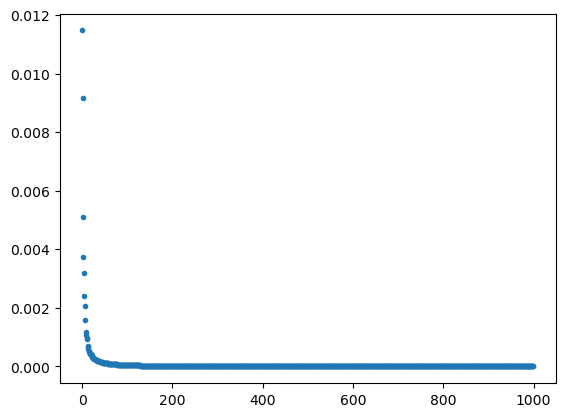

In [51]:
plt.plot(vals,'.')

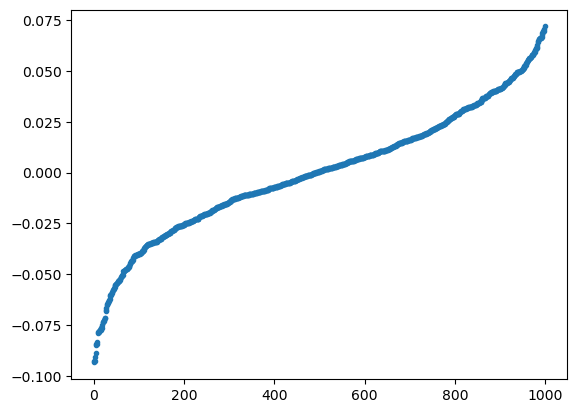

In [52]:
# Pick an eigenvector z

zind = 0
sorted_img_idx = vecs[:,zind].argsort()[::-1]
plt.plot(np.sort(vecs[:,zind]),'.')

In [53]:
sortedz_dist = np.sort(vecs[:,zind])


ValueError: x and y must have same first dimension, but have shapes (1000,) and (1,)

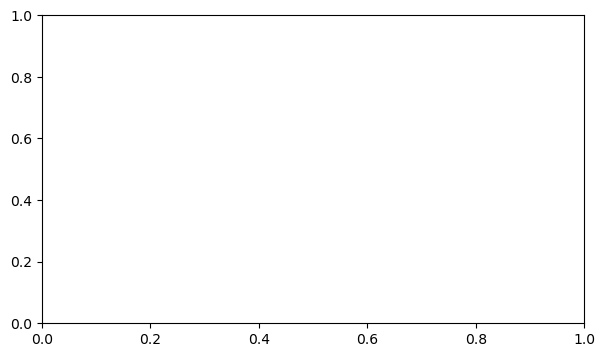

In [34]:

# Create the heatmap

# sortedz = np.sort(vecs[:,zind]),

ndots = 16

# fig, ax = plt.subplots(figsize= (7,4))

# ax.plot(np.arange(0,1000),sortedz_sim[0],'.', color=[0,0,0],alpha=0.5)

# ax.plot(np.arange(1000-ndots,1000), sortedz_sim[0][-ndots:],'.')
# ax.plot(np.arange(0,ndots), sortedz_sim[0][0:ndots],'.')

# plt.savefig('dominant_eigenvector_'+ model_names[ind1] + '_' + model_names[ind2] + '_' + 'similarity.pdf',bbox_inches='tight')


fig, ax = plt.subplots(figsize= (7,4))


ax.plot(np.arange(0,1000),sortedz_dist[0],'.', color=[0,0,0],alpha=0.5)

ax.plot(np.arange(0,ndots), sortedz_dist[0][0:ndots],'.',color=[0, 0.5, 0.4])
ax.plot(np.arange(1000-ndots,1000), sortedz_dist[0][-ndots:],'.',color=[0.7, 0.2, 0.4])


plt.savefig('dominant_eigenvector_'+ model_names[ind1] + '_' + model_names[ind2] + '_' + 'distance.pdf',bbox_inches='tight')


# Add title
# ax.set_title("")

# plt.savefig('dominant_eigenvector_'+ model_names[ind1] + '_' + model_names[ind2] + '_' + 'both.pdf',bbox_inches='tight')

# Display the plot
plt.show()



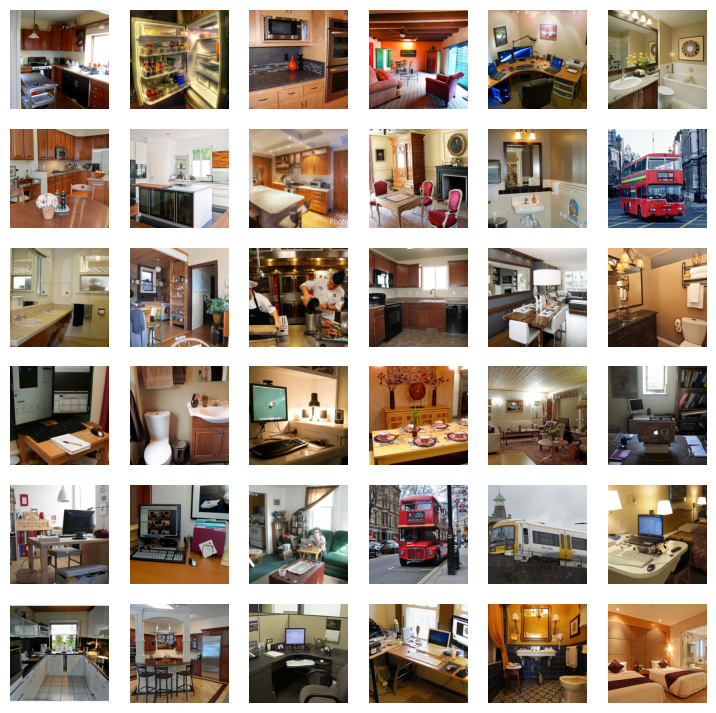

In [54]:
import matplotlib.pyplot as plt

nimgs = 36
ncols = 6
nrows = int(np.ceil(nimgs/ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(9,9))
ind = 0

for row in range(nrows):
    for column in range(ncols):
        if ind == nimgs:
            break
        else:
            image = Y["image_data"]["test"][sorted_img_idx[ind],:,:,:]
            ax = axes[row, column]
            # ax.set_title(f"Image ({row}, {column})")
            ax.axis('off')
            ax.imshow(image)
            ind += 1

plt.savefig('maxmin_image_tiles/distance_maxweights_' + model_names[ind1] + '_' + model_names[ind2] + '_eigvec' + str(zind) + '.pdf')

plt.show()



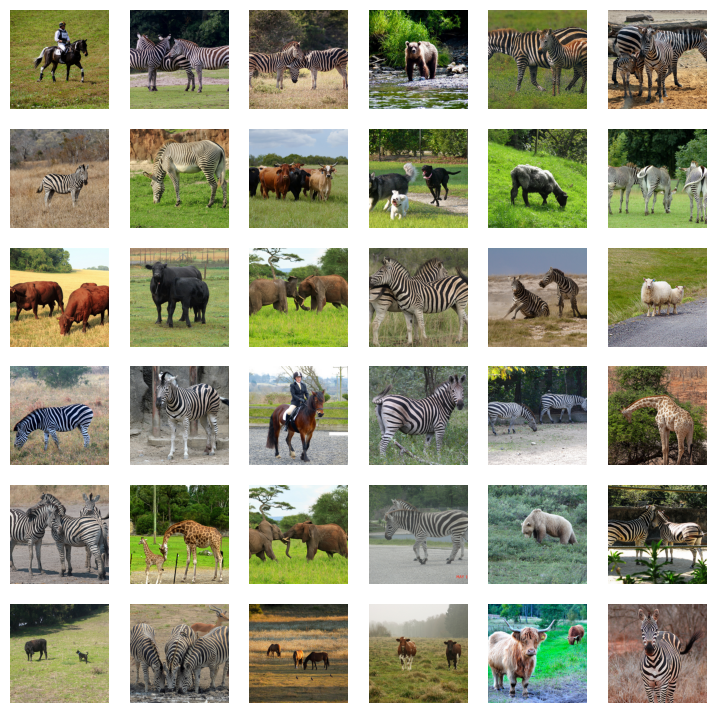

In [55]:
import matplotlib.pyplot as plt

nimgs = 36
ncols = 6
nrows = int(np.ceil(nimgs/ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(9,9))
ind = -1

for row in range(nrows):
    for column in range(ncols):
        if ind == nimgs:
            break
        else:
            image = Y["image_data"]["test"][sorted_img_idx[ind],:,:,:]
            ax = axes[row, column]
            # ax.set_title(f"Image ({row}, {column})")
            ax.axis('off')
            ax.imshow(image)
            ind -= 1

plt.savefig('maxmin_image_tiles/distance_minweights_' + model_names[ind1] + '_' + model_names[ind2] + '_eigvec' + str(zind) + '.pdf')

plt.show()

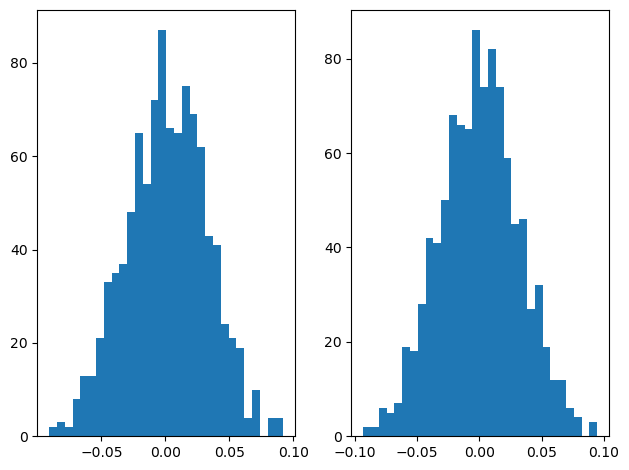

In [1201]:
fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=True)

n_bins = 30

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(vecs[0], bins=n_bins)
axs[1].hist(vecs[-1], bins=n_bins)
# axs[2].hist(vals, bins=n_bins)

plt.show()